# Fully Connected Net

For our least intelligent baseline, just *flatten* all of the layers and train a MLP classifier.

Since the DataLoader has multiple inputs, I think we need to use the module API. 


In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim

# Loading the other modules I have in parent directories
import sys
PYTHONPATH="../"
sys.path.append(PYTHONPATH)
from dataProcessing import getDataLoaders
from models import FCNet, count_parameters
from train import check_accuracy, train
from plottingFcts import trainingMetrics, sigBkgEff, plotROC, plotConfusion

# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

/home/shared/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
loader_train, loader_val, loader_test = getDataLoaders(batch_size=256)

In class, they said the network usually saturated with about 3 different hidden layers, so a default architecture I'm trying has hidden dimensions {150, 100, 50}, although these are hyperparams that I could (possibly) tune. I'm also using batchnorm and dropout!

In [3]:
myModel = FCNet() # h1_dim=300,h2_dim=200,h3_dim=100)

In [4]:
count_parameters(myModel)

96653

#### Sanity check
Before training, the validation accuracy should be about 33%

In [5]:
check_accuracy(loader_val, myModel)

cuda
Got 9596 / 30000 correct (31.99)


### Next step: Train the net!

For simplicity, just use the adam optimizer!


In [6]:
optimizer = optim.Adam(myModel.parameters(), lr = 1e-5)

In [ ]:
np.log(3)

1.0986122886681098

In [ ]:
history, myModel = train(loader_train, loader_val, myModel, optimizer, epochs=60, returnBest=True)


Epoch 1/60:
Iteration 0, loss = 1.1314
cuda
Got 9643 / 30000 correct (32.14)

Iteration 100, loss = 1.0581
cuda
Got 11921 / 30000 correct (39.74)

Iteration 200, loss = 1.0756
cuda
Got 13513 / 30000 correct (45.04)

Iteration 300, loss = 1.0314
cuda
Got 14820 / 30000 correct (49.40)

Iteration 400, loss = 1.0073
cuda
Got 15849 / 30000 correct (52.83)

Iteration 500, loss = 0.9848
cuda
Got 16427 / 30000 correct (54.76)

Iteration 600, loss = 0.9517
cuda
Got 17036 / 30000 correct (56.79)

Iteration 700, loss = 0.9697
cuda
Got 17318 / 30000 correct (57.73)

cuda
Got 103596 / 180000 correct (57.55)
cuda
Got 17211 / 30000 correct (57.37)

Epoch 2/60:
Iteration 0, loss = 0.9453
cuda
Got 17335 / 30000 correct (57.78)

Iteration 100, loss = 0.9567
cuda
Got 17648 / 30000 correct (58.83)

Iteration 200, loss = 0.9132
cuda
Got 17937 / 30000 correct (59.79)

Iteration 300, loss = 0.8872
cuda
Got 18298 / 30000 correct (60.99)

Iteration 400, loss = 0.8926
cuda
Got 18453 / 30000 correct (61.51)

It

Iteration 700, loss = 0.5538
cuda
Got 22269 / 30000 correct (74.23)

cuda
Got 133624 / 180000 correct (74.24)
cuda
Got 22292 / 30000 correct (74.31)

Epoch 14/60:
Iteration 0, loss = 0.5299
cuda
Got 22274 / 30000 correct (74.25)

Iteration 100, loss = 0.5077
cuda
Got 22279 / 30000 correct (74.26)

Iteration 200, loss = 0.5859
cuda
Got 22152 / 30000 correct (73.84)

Iteration 300, loss = 0.5041
cuda
Got 22254 / 30000 correct (74.18)

Iteration 400, loss = 0.5200
cuda
Got 22164 / 30000 correct (73.88)

Iteration 500, loss = 0.5328
cuda
Got 22267 / 30000 correct (74.22)

Iteration 600, loss = 0.5847
cuda
Got 22196 / 30000 correct (73.99)

Iteration 700, loss = 0.5149
cuda
Got 22308 / 30000 correct (74.36)

cuda
Got 133712 / 180000 correct (74.28)
cuda
Got 22366 / 30000 correct (74.55)

Epoch 15/60:
Iteration 0, loss = 0.5674
cuda
Got 22328 / 30000 correct (74.43)

Iteration 100, loss = 0.5081
cuda
Got 22302 / 30000 correct (74.34)

Iteration 200, loss = 0.4726
cuda
Got 22245 / 30000 corre

In [13]:
check_accuracy(loader_val, myModel)

cuda
Got 22778 / 30000 correct (75.93)


## Plot the loss and accuracy curves

- I'm only calculating the accuracies after each epoch, because it was prohibitively slow when I was printing after each iteration.

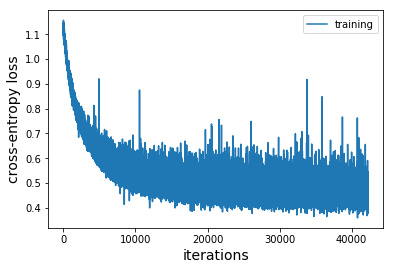

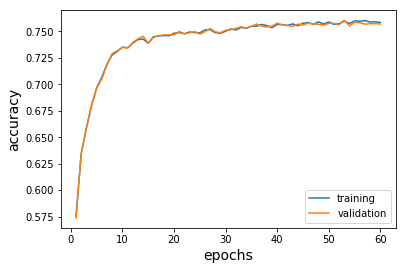

In [14]:
trainingMetrics(history)

## Discriminant plots / ROC Curves

Ok, so for the ROC curves, use the discriminant

$$D_\gamma = \frac{p_\gamma}{p_\pi + p_e}$$

Where $p_i$ corresponds to the output of the softmax node, and this discriminant separates a $\gamma$ signal from a $\pi$ and $e$ background, and we can define similar discriminants for $\pi^+$ or $e^+$ signal.

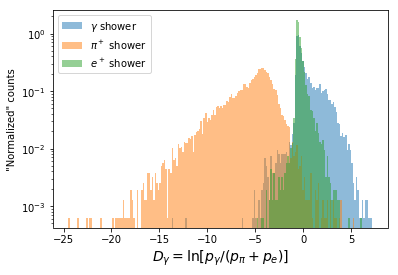

../plottingFcts.py:229: RuntimeWarning: divide by zero encountered in true_divide
  plt.semilogy(teff, np.divide(1,beff), style, color=color, label=label)


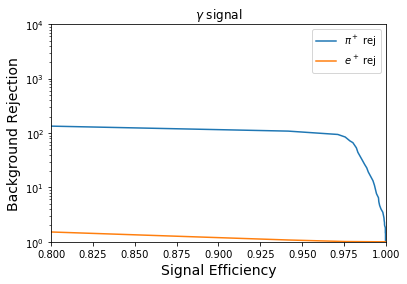

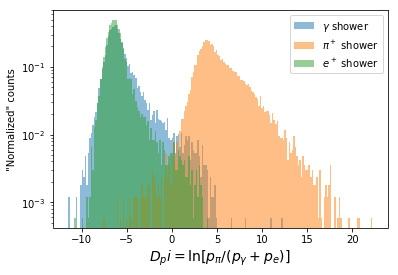

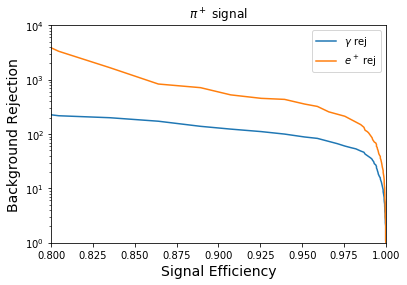

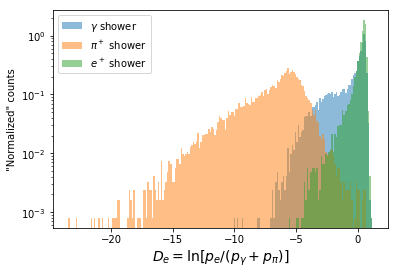

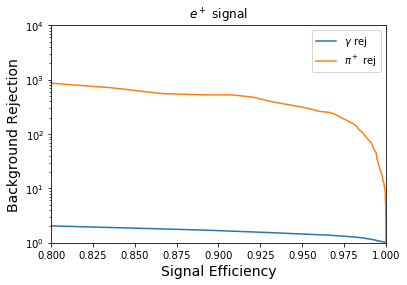

In [15]:
particles = ['gamma','pi','e']

for node in range(3):
    g_eff, pi_eff, e_eff = sigBkgEff(myModel, loader_val, node)
    mTag = '{}-sig_{}'.format(particles[node], myModel.modelName)
    
    # Plot the ROC curve using node as the signal and the other two as the bkg
    if node == 0:
        plotROC([g_eff, g_eff], [pi_eff, e_eff], ['$\pi^+$ rej', '$e^+$ rej'], title='$\gamma$ signal', tag=mTag)
    if node == 1:
        plotROC([pi_eff, pi_eff], [g_eff, e_eff], ['$\gamma$ rej', '$e^+$ rej'], title='$\pi^+$ signal', tag=mTag)
    elif node == 2:
        plotROC([e_eff, e_eff], [g_eff, pi_eff], ['$\gamma$ rej', '$\pi^+$ rej'], title='$e^+$ signal', tag=mTag)
        

**Notes:**

To see which classes we tend to misclassify the most, look at the confusion matrix between the classes.


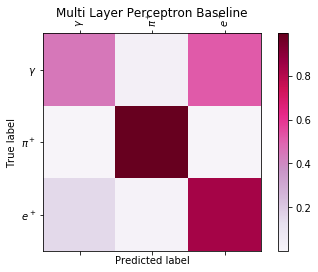

In [16]:
plotConfusion(myModel, loader_val, title="Multi Layer Perceptron Baseline")

# Other Experiments

- I tried a fc model with more hidden neurons: 300-200-100 for 233k trainable parameters, training for 75 epochs with a learning rate $\alpha = 10^{-5}$, but the best validation accuracy I got was ()%, suggesting that my simpler 150-100-50 model was actually sufficiently complex for this architeture.

